# Data Literacy
#### University of Tübingen, Winter Term 2021/22
## Exercise Sheet 8
&copy; 2021 Prof. Dr. Philipp Hennig & Agustinus Kristiadi

This sheet is **due on Monday 20 December 2021 at 10am sharp (i.e. before the start of the lecture).**

### The LFW Dataset

**Task 1.** First order of business: Unzip the `data.zip` file. Then load the LFW [1] images (in the `images` directory) into a matrix $\mathbf{X} \in \mathbb{R}^{13232 \times 1764}$, where each row contains an image vector. Note that the image shape is $49 \times 36$. 

#### References

1. http://vis-www.cs.umass.edu/lfw/

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import tqdm


N = 13232
dim = (49, 36)

X_lfw = np.zeros([N, 49*36])

path = 'data\images'

for file in os.listdir(path):
    if file.startswith("img"):
        file_path = f"{path}\{file}"

        with open(file_path, 'r') as f:
            image_data = np.array(f.read().split(), dtype=np.float32)
            X_lfw[int(file[3:-4])] = image_data


To get a feeling about this dataset, here are 5 random images from LFW.

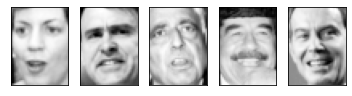

In [2]:
n_images = 5

fig = plt.figure()
for i in range(n_images):
    idx = np.random.randint(len(X_lfw))
    ax = fig.add_subplot(1, n_images, i+1)
    ax.imshow(X_lfw[idx].reshape(dim), cmap='Greys_r')
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

# Principal Component Analysis

The first goal of this sheet is to understand PCA by implementing it. First we will revisit the step-by-step algorithm of PCA and then apply it to the LFW faces dataset. Then we will build our intuition about PCA as a dimensionality reduction technique which tries to minimize the reconstruction error of a given dataset. 
    
As we have seen in the lecture, the algorithm for computing the projection matrix $\mathbf{U}$ containing $k$ principal components is as follows:

1. Compute the data mean $\overline{\mathbf{x}} := \frac{1}{N} \sum_{n=1}^N \mathbf{x}_n$.
2. Compute the centered data matrix $\widehat{\mathbf{X}} := (\mathbf{x}_1 - \overline{\mathbf{x}}, \dots, \mathbf{x}_N - \overline{\mathbf{x}})^\top$.
2. Compute the covariance matrix $\mathbf{C} = \frac{1}{N-1} \widehat{\mathbf{X}}^\top \widehat{\mathbf{X}}$.
3. Do eigendecomposition on the covariance $\mathbf{C} = \mathbf{Q} \, \mathrm{diag}(\boldsymbol{\lambda}) \, \mathbf{Q}^\top$.
4. Pick $k$ columns of $\mathbf{Q}$ corresponding to the $k$ largest eigenvalues in $\boldsymbol{\lambda}$, and arrange them as a matrix $\mathbf{U}$.

Given a data point $\mathbf{x}$, we can compute the its reconstruction w.r.t. to the projection $\mathbf{U}$ via the following steps:

1. Project the point onto the latent space $\mathbf{z} = \mathbf{U}^\top \mathbf{x}$.
2. Obtain the reconstruction by projecting the latent point back onto the data space $\widetilde{\mathbf{x}} = \mathbf{U} \mathbf{z}$.

The reconstruction error $e$ is simply the mean-squared-error between the data $\mathbf{X}$ and their reconstructions $\widetilde{\mathbf{X}}$, i.e.

$$
    e = \frac{1}{N} \sum_{n=1}^N \Vert \mathbf{x}_n - \widetilde{\mathbf{x}}_n \Vert^2_2 .
$$

## Implementing PCA

**Task 2.** Compute the covariance matrix $\mathbf{C} \in \mathbb{R}^{1764 \times 1764}$. And do eigendecomposition on $\mathbf{C}$ to get $\mathbf{Q}$ and $\boldsymbol{\lambda}$.

In [3]:
# compute mean
mean = np.mean(X_lfw)

# center matrix
X_lfw_centered = X_lfw - mean

# compute covariance matrix
cov_X_lfw = (1/N) * X_lfw_centered.T @ X_lfw_centered 

# compute lambda and Q
l, Q = np.linalg.eig(cov_X_lfw)
# sort by size of eigenvector
sorted_idx = np.argsort(l)[::-1]
l = l[sorted_idx]
Q = Q[:, sorted_idx]

Note that the columns of $\mathbf{Q}$ are basis vectors for the data. I.e., each LFW image can be written as a linear combination of these vectors. It is therefore interesting to see what do these basis vectors looks like as images. Let's show the first $5$ eigenvectors in $\mathbf{Q}$.

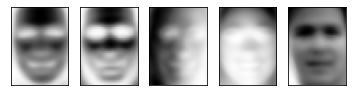

In [4]:
n_images = 5

fig = plt.figure()

for i in range(n_images):
    ax = fig.add_subplot(1, n_images, i+1)
    ax.imshow(Q[:, i].reshape(dim), cmap='Greys_r')
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

**Task 3.** Compute the projected and reconstructed data using the first $k$ basis vectors. Compare an image with their corresponding reconstruction. Do you observe a relationship between $k$ and the reconstruction quality?

_Hint:_ Since we arrange our data in a matrix, the formula for $\mathbf{z}$ and $\widetilde{\mathbf{x}}$ might be slightly different. The main point is to get matrices $\mathbf{Z} \in \mathbb{R}^{13232 \times k}$ and $\widetilde{\mathbf{X}} \in \mathbb{R}^{13232 \times 1764}$.

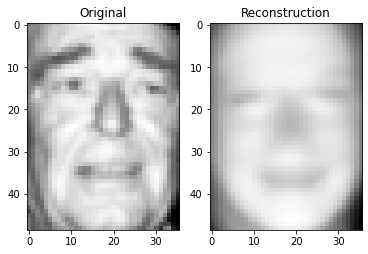

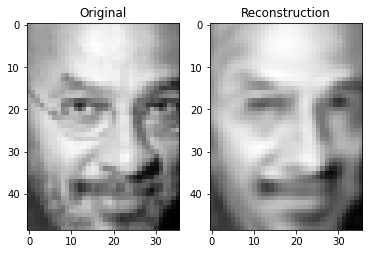

In [6]:
def reconstruct(X, U):
    """
    Reconstruct images using the first-k eigenvectors.
    
    Params:
    -------
    X: Data matrix of shape (13232, 1764)
    U: Projection matrix consisting of the first-k eigenvectors. The shape is (1764, k)
    
    Returns:
    --------
    X_tilde: The reconstructed data matrix. The shape is (13232, 1764)
    """
    Z = X @ U
    X_tilde = Z @ U.T
    
    return X_tilde


# The reconstruction of X using the first k basis vectors
for k in [10, 200]:
    X_tilde_lfw = reconstruct(X_lfw, Q[:, :k])

    # Show a random original image and its reconstruction
    idx = np.random.randint(len(X_lfw))

    fig = plt.figure()

    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(X_lfw[idx].reshape(dim), cmap='Greys_r')
    ax1.title.set_text('Original')

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.imshow(X_tilde_lfw[idx].reshape(dim), cmap='Greys_r')
    ax2.title.set_text('Reconstruction')

    plt.show()

**Task 4.** Let us now quantify the reconstruction error. Create a function that takes the original data and a projection matrix. Compare the errors when $k=5$ and $k=200$. What do you notice?

In [7]:
def get_error(X, U):
    """
    Get the reconstruction error using the first-k eigenvectors.
    
    Params:
    -------
    X: Data matrix of shape (13232, 1764)
    U: Projection matrix consisting of the first-k eigenvectors. The shape is (1764, k)
    
    Returns:
    --------
    error: The mean-squared-error between the original data and the reconstruction
    """
    X_tilde = reconstruct(X, U)
    error = np.mean((X_tilde - X)**2)
    
    return error


print(f'{get_error(X_lfw, Q[:, :10]):.1f}')
print(f'{get_error(X_lfw, Q[:, :200]):.1f}')

708.0
57.9


Not surprisingly, the error is lower for increased k. The relationship is not linear.

---
---

# t-SNE

We have seen how we can do simple dimensionality reduction using PCA: just pick several eigenvectors. With $k=2$ latent dimension, a high-dimensional dataset is amenable for visualization. However, PCA is linear model---it might not be able to capture nonlinear relationships between the data and their embeddings. 

Nonlinear embedding algorithms have thus been proposed. t-SNE [2] uses a heavy-tailed function to measure distance between any pair of data. This way, we can represent the data as a collection of vertices and weighted edges---a graph. The normalized distances can further be interpreted as probabilities. The goal is then to find a graph, embedded in the latent space, that is close to the original data's graph as measured by KL-divergence.

In this exercise, we implement t-SNE. The goal main goal is to understand the behind-the-scene of t-SNE better so that we can better utilize it. This is important since t-SNE's hyperparameters are impactful to the end results.

#### References

2. Maaten, Laurens van der, and Geoffrey Hinton. "Visualizing data using t-SNE." Journal of machine learning research 9.Nov (2008): 2579-2605.

## Implementing t-SNE

**Task 5.** Read the t-SNE paper, especially Section 1-3.


For convenience here is a summary of the t-SNE's algorithm.

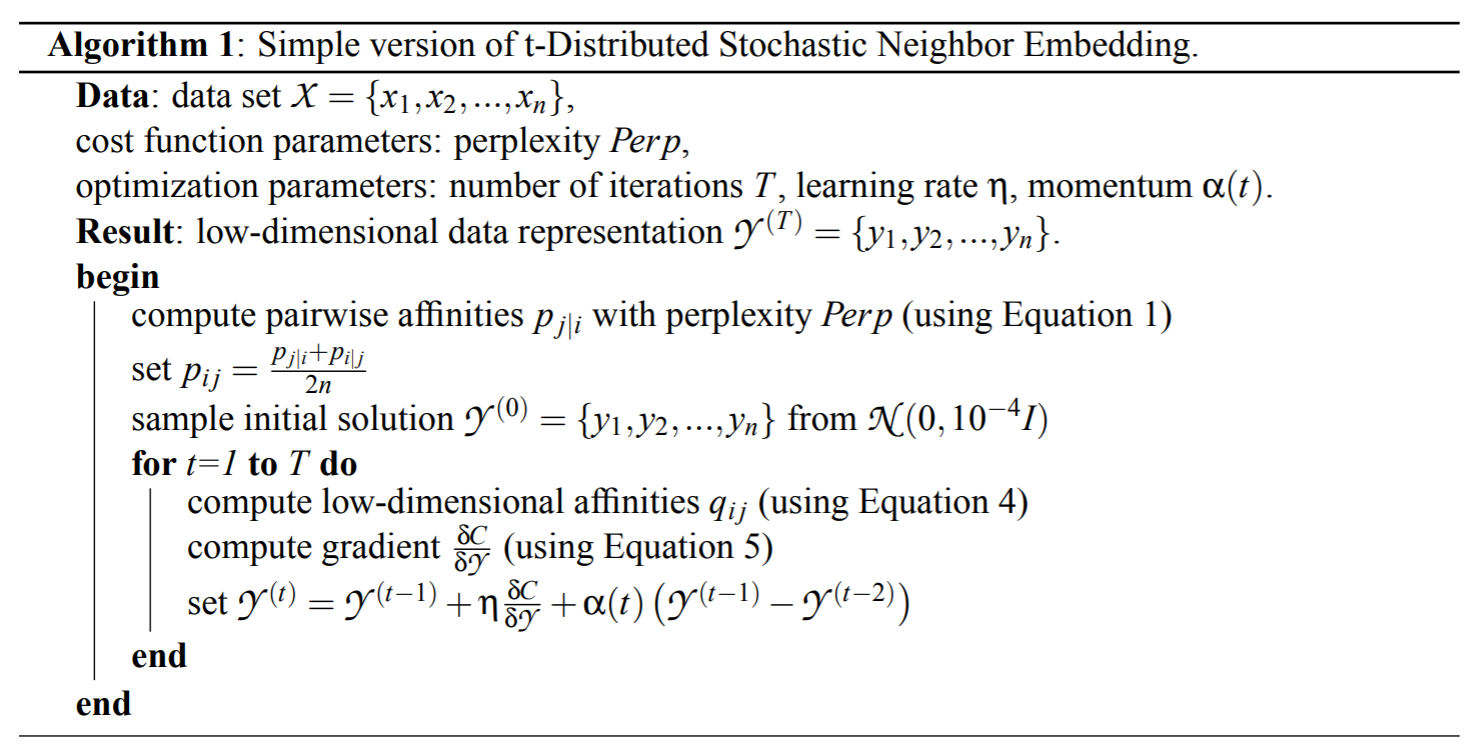

In [8]:
from IPython.display import Image
Image(filename='tsne_algo.png', width=600)

In the above, $Perp$ is a hyperparameter that represent the target perplexity of low-dimensional representations. Meanwhile, $T$, $\eta$, and $\alpha(t)$ are gradient descent's hyperparameters for optimization.

### Step 1. Computing symmetric pairwise affinities

Our first step is to compute each symmetric pairwise affinity $p_{ij}$ given a pair of points $x_i$ and $x_j$.

In [9]:
import scipy.spatial.distance as scidist


# Pairwise squared Euclidean distance
def get_dists(Z):
    """
    Compute all pairwise distances of each data points z_i in Z.
    
    Params:
        Z: matrix with n rows. Each row is the z_i
        
    Return:
        All pairwise distances of each data points z_i in Z
    """
    dists = scidist.pdist(Z, metric='sqeuclidean')  
    return scidist.squareform(dists)

Now recall that for each $i$ we need to compute $p_{j|i}$ that attains the desired perplexity value `perp`. The function for computing $\beta_i$'s that achieve $Perp$ perplexity is available in `tsne_util.py`---it is simply a binary search algorithm.

In [10]:
import math
import tsne_util



def get_perplexity(p):
    """
    Returns the perplexity of p. See https://en.wikipedia.org/wiki/Perplexity
    
    Params:
        p: probability vector
        
    Return:
        A single number---the perplexity of p
    """
    entropy = -np.sum(p * np.log2(p + 1e-10))
    return 2**entropy


def get_beta(perp, dists_X):
    """
    Let beta_i := 2 \sigma_i^2. This function computes (beta_i) that achieve
    the desired perplexity.
    
    Params:                 
        perp: Desired perplexity value.
        
        dists_X: Pairwise squared Euclidean distances between points in X, stored in an (n x n)-matrix
                
    Returns:
        betas: (n,) array of beta_i's 
    """    
    return tsne_util.binary_search(perp, dists_X, get_perplexity)

The conditional probability $p_{j | i}$ is defined by

$$
    p_{j | i} := p(x_j | x_i) := \frac{\exp(-\Vert x_i - x_j \Vert^2) / \beta_i}{\sum_{k \neq i} \exp(-\Vert x_i - x_k \Vert^2 / \beta_i)} \qquad \text{where} \enspace p_{i|i} = 0 ,
$$

where each $\beta_i$ is obtained in such a way that it (approximately) achieves the desired perplexity value $Perp$. Here is a function for computing them.

In [11]:
def get_p_j_given_i(dists_X, perp):
    """
    Compute the conditional probabilities p_{j|i}'s
    
    Params
        dists_X: pairwise-distances matrix of X
        perp: the desired perplexity level (single number)

    Return:
        (n, n) matrix containing p_{j|i}'s
    """
    betas = get_beta(perp, dists_X)

    p_j_given_i = np.exp(-dists_X / betas[None, :])
    np.fill_diagonal(p_j_given_i, 0)
    p_j_given_i /= p_j_given_i.sum(1, keepdims=True)
    
    return p_j_given_i

The joint probability $p_{ij}$ is

$$
    p_{ij} := \frac{p_{j|i} + p_{i|j}}{2n} \qquad \text{where} \enspace p_{ii} = 0 ,
$$

for all $i, j \in \{ 1, \dots, n \}$. We assume that the matrix containing all $p_{ij}$ is denoted by $P \in \mathbb{R}^{n \times n}$.


**Task 6.** Now, write a function for computing all the joint probabilities $p_{ij}$, i.e. computing $P$. You should end up with an $n \times n$ matrix with $p_{ii} = 0$ for all $i=1, \dots, n$, and $\sum_{i=1}^n \sum_{j=1}^n p_{ij} = 1$.

In [14]:
def get_P(dists_X, perp):
    """
    Compute the joint probabilities p_ij's
    
    Params
        dists_X: pairwise-distances matrix of X
        perp: the desired perplexity level (single number)

    Return:
        (n, n) matrix P containing p_ij's
    """
    P = get_p_j_given_i(dists_X, perp)
    N = P.shape[0]
    P_sym = ((P + P.T) * (1 - np.eye(N))) / (2 * N)
    
    return P_sym

### Step 2. Computing best low-dimensional representations

Now we are going to address the steps inside the loop in the algorithm above. 

The low-dimensional affinities $q_{ij}$ is defined by 

$$
    q_{ij} := \frac{(1 + \Vert y_i - y_j \Vert^2)^{-1}}{\sum_{k \neq l} (1 + \Vert y_k - y_l \Vert^2)^{-1}}  \qquad \text{where} \enspace q_{ii} = 0 ,
$$

for all $i, j \in \{1, \dots, n\}$. We assume that the matrix containing all $q_{ij}$ is denoted by $Q \in \mathbb{R}^{n \times n}$.

<!-- **Task.** Construct a function that outputs $q_{ij}$'s (i.e. $Q$) given distances between $y_i$ and $y_j$. The input of this function is an $n \times n$ matrix containing all pairwise distances between $y_i$'s and $y_j$'s. The return value of this function should be an $n \times n$ matrix $Q$, where each row is a valid probability distribution, i.e. $q_{ij} \geq 1$ and $\sum_{i=1}^n \sum_{j=1}^n q_{ij} = 1$. Note that $q_{ii} = 0$ for all $i = 1, \dots, n$. -->

In [15]:
def get_Q(dists_Y):    
    """
    Compute low-dimensional affinities q_ij
    
    Params
        dists_Y: (n, n) matrix containing all pairwise distances of elements of Y

    Return:
        (n, n) matrix Q containing q_ij's
    """
    Q = 1/(1 + dists_Y)
    np.fill_diagonal(Q, 0)
    Q /= Q.sum()
    
    return Q

The cost function---the function we are going to optimize in order to find an optimal embedding $\mathcal{Y}$---is the KL-divergence between $P$ and $Q$:

$$
    C := D_\text{KL}(P \Vert Q) := \sum_{i=1}^n \sum_{j=1}^n p_{ij} \log \frac{p_{ij}}{q_{ij}} .
$$

Since we need to minimize $C$ via gradient descent, we need its gradient:

$$
    \frac{\partial C}{\partial y_i} = 4 \sum_{j=1}^n \frac{(p_{ij} - q_{ij}) (y_i - y_j)}{1 + \Vert y_i - y_j \Vert^2} .
$$


**Task 7.** For the final task in this step, write a function that computes the $n$ gradient vectors $\left\{ \frac{\partial C}{\partial y_i} \right\}_{i=1}^n$ given $Y$, $P$, $Q$, and all pairwise distances between $y_i$ and $y_j$. Note that each gradient is a vector of length `N_PROJ_DIM`.

In [38]:
def get_grad(Y, P, Q, dists_Y):
    """
    Compute the KL-divergence gradient
    
    Params
        Y: (n, N_PROJ_DIM) matrix
        P: (n, n) matrix
        Q: (n, n) matrix
        dists_Y: (n, n) matrix containing all pairwise distances of elements of Y

    Return:
        (n, N_PROJ_DIM) matrix---each row is the gradient dC/dy_i
    """
    grad = np.zeros_like(Y)

    PQ_dif = P - Q 
    for i in range(Y.shape[0]):

        Y_i_dif = Y[i] - Y
        numerator = (PQ_dif[i].reshape(-1, 1) * Y_i_dif)
        frac =  numerator / (1 + dists_Y[i].reshape(-1, 1))
        grad[i] = 4 * np.sum(frac, axis=0)
        
    return grad

### Step 3. Optimization

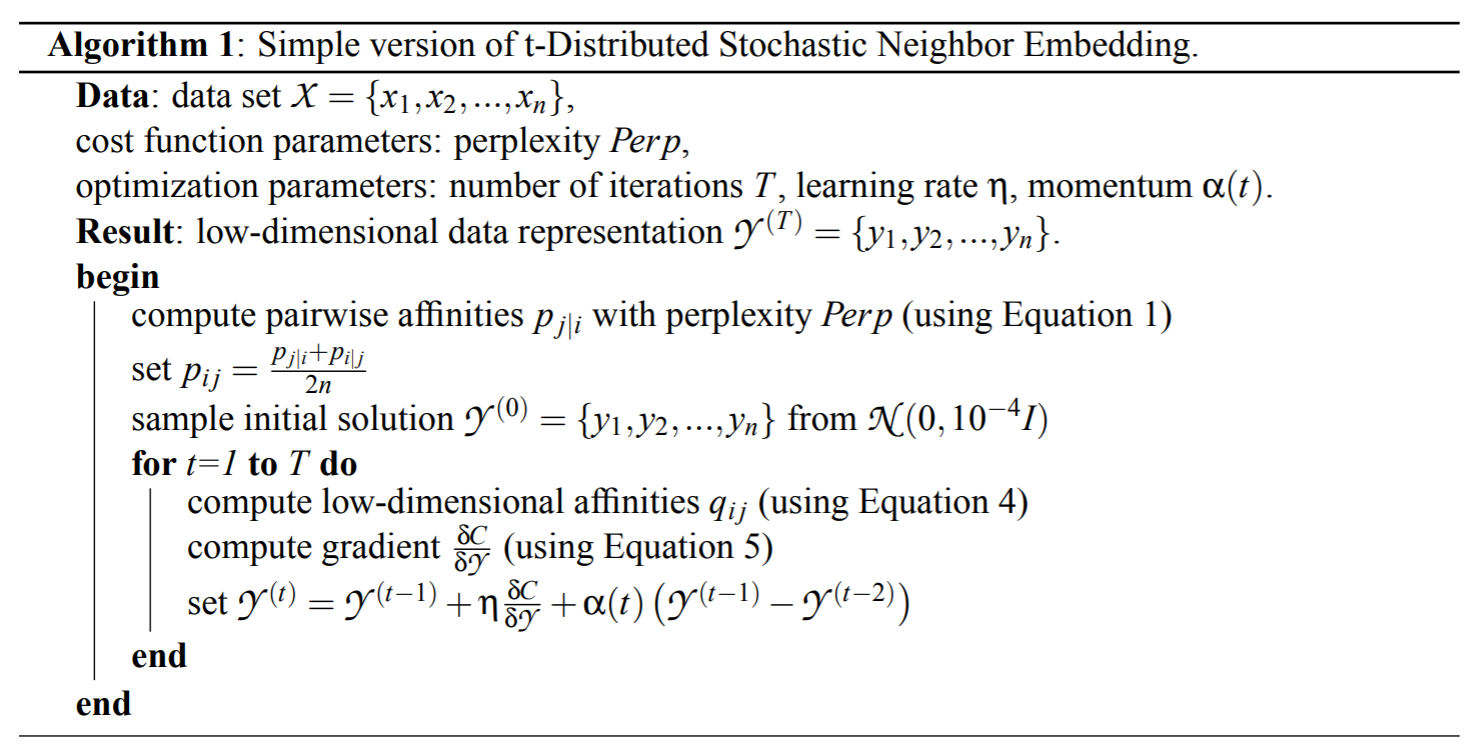

In [39]:
Image(filename='tsne_algo.png', width=600)

Since we now have all the necessary ingredients, we are finally ready run the full algorithm. The implementation of the pseudocode is given below.

**Note.** To test the algorithm, look at the plots generated by the test code below. Your aim is to be "better" than PCA---slightly worse than Scikit-Learn's implementation is to be expected. "Better" here is subjective, but the rule of thumb is to obtain a 2D representations that minimize **intra**-cluster distances and maximize **inter**-cluster distances.

In [68]:
# Feel free to experiment with different values
perp = 15


""" DO NOT MODIFY ANYTHING BELOW THIS!!! """
""" ------------------------------------ """

from tqdm import trange
from sklearn.datasets import load_iris

N_PROJ_DIM = 2

# Load dataset
X_iris, y_iris = load_iris(return_X_y=True)


def my_tsne(X, perp, T=1000, eta=200):
    np.random.seed(423)
    
    dists_X = get_dists(X)
    P = get_P(dists_X, perp)
    Y = np.random.randn(len(X), N_PROJ_DIM) * 10**(-2)  # Each sampled from N(0, 10^-4)
    v = 0  # veloctiy for Momentum-Gradient-Descent

    progress_bar = trange(T)

    for t in progress_bar:
        dists_Y = get_dists(Y)
        Q = get_Q(dists_Y)

        kl_loss = np.sum(P * (np.log(P+1e-10) - np.log(Q+1e-10)))

        # An alternative way (relative to the one in the paper) to do gradient descent + momentum
        grads = get_grad(Y, P, Q, dists_Y)
        alpha = 0.5 if t < 250 else 0.8
        v = alpha*v + eta*grads
        Y -= v
        
        if t % T//20 == 0:
            progress_bar.set_description(f'[KL-loss: {kl_loss:.3f}]')

    return Y

### Step 4. Running and evaluating the implementation

Finally, we can run our own t-SNE implementation. To validate the correctness of our implementation, we compare the result of our t-SNE against `scikit-learn`'s t-SNE embeddings.

_Note._ There will of course be some difference since our implementation is quite "naive" compare to `scikit-learn`'s. But, if you implemented it correctly, you will see similar embedding plots below.

[KL-loss: 0.592]: 100%|██████████| 1000/1000 [00:03<00:00, 330.61it/s]


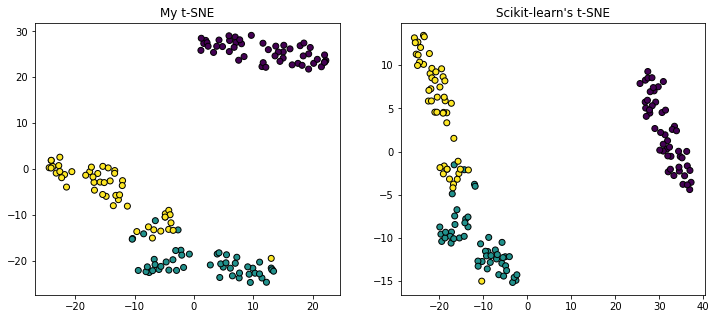

In [69]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

Z = my_tsne(X_iris, perp=perp)
axs[0].scatter(Z[:, 0], Z[:, 1], c=y_iris, edgecolors='k');
axs[0].set_title('My t-SNE');

# Compare against scikit-learn's tSNE
from sklearn.manifold import TSNE

Z_sklearn = TSNE(perplexity=perp, random_state=3).fit_transform(X_iris)

axs[1].scatter(Z_sklearn[:, 0], Z_sklearn[:, 1], c=y_iris, edgecolors='k');
axs[1].set_title('Scikit-learn\'s t-SNE');

**Task 8.** Try different perplexity values and write your observations below. What happens when $Perp$ is very small, say $2$? What happens when it is very large, e.g. $1000$? The original t-SNE paper recommends perplexity values between $5$ and $50$. Do you agree with this?

**Answer.** 
A very small perp value leads to lots of small, separated clusters in the naive implementation and to one cluster (with outliers) for the scikit algorithm. Large perplexities lead to almost all points being connected and no clusters being visible.  
A perplexity value of 15-20 seems to yield the best results and lies within the 5-50 range, so the recommendation seems reasonable for the given problem. 

---

Last but not least, here we see that t-SNE is _not_ fool-proof! On the (subset of the) LFW dataset, we can see that t-SNE does not give interpretable results with the default hyperparameter values.

[KL-loss: 1.026]: 100%|██████████| 1000/1000 [00:05<00:00, 191.58it/s]


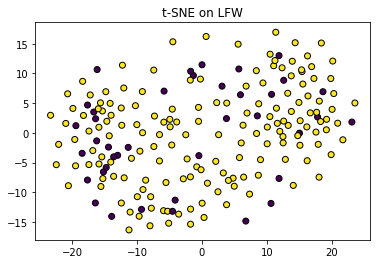

In [42]:
from sklearn.utils import resample

# Label for each image (i.e. the sex of the person)
y_lfw = np.loadtxt(f'data/images/sex.txt').ravel().astype('int8')

# Subsample data to make things quicker
X_lfw_small, y_lfw_small = resample(X_lfw, y_lfw, n_samples=200, random_state=99)

# Do t-SNE
Z_lfw = my_tsne(X_lfw_small, perp=30)

plt.scatter(Z_lfw[:, 0], Z_lfw[:, 1], c=y_lfw_small, edgecolors='k');
plt.title('t-SNE on LFW');